# 03 - NeuralProphet Implementation

This notebook implements NeuralProphet for forecasting Walmart store revenues.

## Key Features:
- **Neural network-based** trend and seasonality modeling
- **Calendar events** as external regressors
- **Per-store models** for better individual store predictions
- **Automatic seasonality** detection (daily, weekly, yearly)

**Target**: Beat competition baseline RMSE of 11,761

## 1. Setup and Installations

In [4]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_all_data, get_store_data, parse_submission_id
from src.evaluation import rmse, holdout_validation

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

# Competition baseline to beat
COMPETITION_BASELINE = 11761

## 2. Load and Prepare Data

In [5]:
# Load data
train_df, calendar_df, submission_df = load_all_data()

print(f"Training data shape: {train_df.shape}")
print(f"Date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Stores: {sorted(train_df['store_id'].unique())}")
print(f"\nCalendar events shape: {calendar_df.shape}")
print(f"Unique events: {calendar_df['event'].nunique()}")

Training data shape: (18766, 4)
Date range: 2011-01-29 00:00:00 to 2015-09-30 00:00:00
Stores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Calendar events shape: (162, 2)
Unique events: 34


In [6]:
# Create holdout validation set (90 days)
train_set, holdout_set = holdout_validation(train_df, holdout_days=90)

print(f"Train set: {len(train_set)} rows")
print(f"Train date range: {train_set['date'].min()} to {train_set['date'].max()}")
print(f"\nHoldout set: {len(holdout_set)} rows")
print(f"Holdout date range: {holdout_set['date'].min()} to {holdout_set['date'].max()}")

Train set: 17776 rows
Train date range: 2011-01-29 00:00:00 to 2015-07-02 00:00:00

Holdout set: 990 rows
Holdout date range: 2015-07-03 00:00:00 to 2015-09-30 00:00:00


## 3. Prepare Calendar Events as Regressors

NeuralProphet can use external regressors. We'll create binary event indicators for major calendar events.

In [14]:
FUTURE_REGRESSORS = [
    'is_major_holiday',
    'is_sports_event',
    'is_religious_event',
    'month',
    'is_weekend'
]

In [13]:
def prepare_calendar_features(df, calendar_df):
    """
    Add calendar event features to dataframe.
    
    Creates binary indicators for major event categories:
    - Holidays (Christmas, Thanksgiving, etc.)
    - Sports events (SuperBowl, NBA Finals, etc.)
    - Religious events (Easter, Ramadan, etc.)
    """
    df = df.copy()
    df['month'] = df['date'].dt.month
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)
    df['day_of_week'] = df['date'].dt.dayofweek  # optional, NeuralProphet has weekly_seasonality

    # if 'revenue' in df.columns:
    #     H = 92
    #     for window in [7, 14, 28]:
    #         df[f'rolling_mean_{window}'] = df.groupby('store_id')['revenue'].transform(
    #             lambda x: x.shift(H).rolling(window, min_periods=1).mean()
    #         )

    # Parse calendar dates (DD/MM/YYYY format)
    calendar_df = calendar_df.copy()
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], format='%d/%m/%Y')
    
    # Define event categories
    major_holidays = ['Christmas', 'Thanksgiving', 'NewYear', 'IndependenceDay', 
                      'MemorialDay', 'LaborDay', 'ValentinesDay', "Mother's day", 
                      "Father's day"]
    sports_events = ['SuperBowl', 'NBAFinalsStart', 'NBAFinalsEnd']
    religious_events = ['Easter', 'OrthodoxEaster', 'LentStart', 'Ramadan starts', 
                        'Eid al-Fitr', 'Pesach End']
    
    # Initialize event columns
    df['is_major_holiday'] = 0
    df['is_sports_event'] = 0
    df['is_religious_event'] = 0
    
    # Mark events
    for _, row in calendar_df.iterrows():
        event_date = row['date']
        events = [e.strip() for e in str(row['event']).split(',')]
        
        mask = df['date'] == event_date
        
        for event in events:
            if event in major_holidays:
                df.loc[mask, 'is_major_holiday'] = 1
            if event in sports_events:
                df.loc[mask, 'is_sports_event'] = 1
            if event in religious_events:
                df.loc[mask, 'is_religious_event'] = 1
    
    return df

# Apply calendar features
train_set_with_events = prepare_calendar_features(train_set, calendar_df)
holdout_set_with_events = prepare_calendar_features(holdout_set, calendar_df)

print("Event feature summary:")
print(f"Major holidays: {train_set_with_events['is_major_holiday'].sum()} days")
print(f"Sports events: {train_set_with_events['is_sports_event'].sum()} days")
print(f"Religious events: {train_set_with_events['is_religious_event'].sum()} days")

Event feature summary:
Major holidays: 440 days
Sports events: 165 days
Religious events: 297 days


In [6]:
train_set_with_events.head(10)

,store_id,store_name,date,revenue,month,is_weekend,day_of_week,is_major_holiday,is_sports_event,is_religious_event
0,0,All Stores,2011-01-29,204126.52,1,1,5,0,0,0
1,0,All Stores,2011-01-30,197426.42,1,1,6,0,0,0
2,0,All Stores,2011-01-31,144267.27,1,0,0,0,0,0
3,0,All Stores,2011-02-01,151903.00,2,0,1,0,0,0
4,0,All Stores,2011-02-02,117399.88,2,0,2,0,0,0
5,0,All Stores,2011-02-03,173443.45,2,0,3,0,0,0
6,0,All Stores,2011-02-04,171972.65,2,0,4,0,0,0
7,0,All Stores,2011-02-05,233619.38,2,1,5,0,0,0
8,0,All Stores,2011-02-06,208743.90,2,1,6,0,1,0
9,0,All Stores,2011-02-07,162911.75,2,0,0,0,0,0


## 4. Data Preparation for NeuralProphet

NeuralProphet requires:
- Column `ds` for dates (datetime)
- Column `y` for target values (float)
- Additional columns for regressors

In [15]:
def prepare_neuralprophet_data(df, store_id):
    """
    Prepare data for NeuralProphet format.
    
    Args:
        df: DataFrame with columns [date, revenue, store_id, event features]
        store_id: Store ID to filter
    
    Returns:
        DataFrame with columns [ds, y, event features]
    """
    store_df = df[df['store_id'] == store_id].copy()
    store_df = store_df.sort_values('date').reset_index(drop=True)
    
    # Rename columns for NeuralProphet
    prophet_df = pd.DataFrame({
        'ds': store_df['date'],
        'y': np.log1p(store_df['revenue'])
    })
    
    # Add event features if they exist
    if 'is_major_holiday' in store_df.columns:
        prophet_df['is_major_holiday'] = store_df['is_major_holiday'].values
    if 'is_sports_event' in store_df.columns:
        prophet_df['is_sports_event'] = store_df['is_sports_event'].values
    if 'is_religious_event' in store_df.columns:
        prophet_df['is_religious_event'] = store_df['is_religious_event'].values
    if 'month' in store_df.columns:
        prophet_df['month'] = store_df['month'].values
    if 'is_weekend' in store_df.columns:
        prophet_df['is_weekend'] = store_df['is_weekend'].values

    # for col in ['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28']:
    #   if col in store_df.columns:
    #       prophet_df[col] = np.log1p(store_df[col].values)
    
    return prophet_df

# Test with Store 0
test_df = prepare_neuralprophet_data(train_set_with_events, 0)
print("Sample NeuralProphet data format:")
print(test_df.head(10))
print(f"\nShape: {test_df.shape}")

Sample NeuralProphet data format:
          ds          y  is_major_holiday  is_sports_event  \
0 2011-01-29  12.226500                 0                0   
1 2011-01-30  12.193126                 0                0   
2 2011-01-31  11.879430                 0                0   
3 2011-02-01  11.931004                 0                0   
4 2011-02-02  11.673350                 0                0   
5 2011-02-03  12.063613                 0                0   
6 2011-02-04  12.055097                 0                0   
7 2011-02-05  12.361453                 0                0   
8 2011-02-06  12.248868                 0                1   
9 2011-02-07  12.000970                 0                0   

   is_religious_event  month  is_weekend  
0                   0      1           1  
1                   0      1           1  
2                   0      1           0  
3                   0      2           0  
4                   0      2           0  
5                   0    

In [16]:
print(test_df.tail(10))

             ds          y  is_major_holiday  is_sports_event  \
1606 2015-06-23  12.408848                 0                0   
1607 2015-06-24  12.368557                 0                0   
1608 2015-06-25  12.366423                 0                0   
1609 2015-06-26  12.498569                 0                0   
1610 2015-06-27  12.657313                 0                0   
1611 2015-06-28  12.696090                 0                0   
1612 2015-06-29  12.457735                 0                0   
1613 2015-06-30  12.378362                 0                0   
1614 2015-07-01  12.546745                 0                0   
1615 2015-07-02  12.649395                 0                0   

      is_religious_event  month  is_weekend  
1606                   0      6           0  
1607                   0      6           0  
1608                   0      6           0  
1609                   0      6           0  
1610                   0      6           1  
1611    

## 5. Train NeuralProphet Models

We'll train separate NeuralProphet models for each store with optimized hyperparameters.

In [20]:
def train_neuralprophet_model(train_df, store_id, forecast_horizon, add_regressors=True, verbose=False,
                               epochs=100, n_lags=28, learning_rate=0.01):
    """
    Train NeuralProphet model for a specific store.
    
    Args:
        train_df: Training dataframe with event features
        store_id: Store ID
        add_regressors: Whether to include calendar event regressors
        verbose: Print training progress
        epochs: Number of training epochs (default 100, try 200-500 for better results)
        n_lags: Number of lag days for AR component (default 28, try 56 for 8 weeks)
        learning_rate: Learning rate (default 0.01)
    
    Returns:
        Trained NeuralProphet model
    """
    # Prepare data
    df = prepare_neuralprophet_data(train_df, store_id)
    
    # Initialize model with optimized parameters
    model = NeuralProphet(
        growth='linear',                    # Linear trend
        n_changepoints=10,                  # Allow 10 trend changepoints
        changepoints_range=0.9,             # Use 90% of data for changepoint detection
        yearly_seasonality=True,            # Enable yearly seasonality
        weekly_seasonality=True,            # Enable weekly seasonality
        daily_seasonality=False,            # Disable daily (not needed for daily data)
        seasonality_mode='additive',        # Additive seasonality
        seasonality_reg=0.1,                # Regularization for seasonality
        n_forecasts=forecast_horizon,                    
        n_lags=n_lags,                      # Configurable lag days
        ar_layers=[32, 32],                 # 2 AR layers with 32 units each
        learning_rate=learning_rate,        # Configurable learning rate
        epochs=epochs,                      # Configurable training epochs
        batch_size=32,                      # Batch size
        normalize='auto',
        drop_missing=True,                   # Auto-normalize data
        trainer_config={
            'logger': False,                # DISABLE lightning logging
            'enable_progress_bar': verbose, # Only show progress if verbose
        }
    )
    
    # Add regressors if requested
    if add_regressors:
        for col in FUTURE_REGRESSORS:
            model.add_future_regressor(col)
        
    
    # Train model
    metrics =  model.fit(df, freq='D', validation_df=None, progress=None if not verbose else 'bar')
    model.forecast_horizon = forecast_horizon
    
    return model, df



In [ ]:
# Test training on Store 0 with fine-tuning options


print("Training NeuralProphet model for Store 0 (All Stores)...")
print("Using: epochs=100, n_lags=28 (baseline settings)")
test_model, test_data = train_neuralprophet_model(train_set_with_events, 0, 90, verbose=True)
test_model.set_plotting_backend("plotly-static")
print("\nModel training completed!")

Training NeuralProphet model for Store 0 (All Stores)...
Using: epochs=100, n_lags=28 (baseline settings)


NameError: name 'test_model' is not defined

## 6. Make Predictions on Holdout Set

In [ ]:


def predict_neuralprophet(model, train_df, holdout_df, store_id):
      """
      Make predictions using trained NeuralProphet model.
      """
      # Prepare training data
      train_prophet = prepare_neuralprophet_data(train_df, store_id)

      # Get future dates info
      store_future = holdout_df[holdout_df['store_id'] == store_id].copy()
      store_future = store_future.sort_values('date').reset_index(drop=True)
      n_future = len(store_future)

      # Create future rows manually
      future_rows = pd.DataFrame({
          'ds': store_future['date'].values,
          'y': [None] * n_future  # NeuralProphet expects y column (will be NaN for future)
      })

      # Add all future regressors
      for col in FUTURE_REGRESSORS:
          if col in store_future.columns:
              future_rows[col] = store_future[col].values
          else:
              future_rows[col] = 0

      # Combine historical + future data
      combined_df = pd.concat([train_prophet, future_rows], ignore_index=True)

      # Make predictions
      forecast = model.predict(combined_df)

      # Extract only the future predictions
      train_end_date = train_prophet['ds'].max()
      future_forecast = forecast[forecast['ds'] > train_end_date].reset_index(drop=True)

      # Get predictions - use yhat1 for single-step or handle multi-step
      if 'yhat1' in future_forecast.columns:
          # Multi-step forecast - need to extract diagonal
          predictions = []
          for i in range(min(n_future, len(future_forecast))):
              col_name = f'yhat{i+1}'
              if col_name in future_forecast.columns and i < len(future_forecast):
                  predictions.append(future_forecast.loc[i, col_name])
              elif 'yhat1' in future_forecast.columns:
                  predictions.append(future_forecast.loc[i, 'yhat1'])
          predictions = np.array(predictions, dtype=float)
      else:
          predictions = future_forecast['yhat'].values

      # Inverse log transform
      predictions = np.expm1(predictions)

      # Ensure we have the right number of predictions
      if len(predictions) < n_future:
          # Pad with last value if needed
          last_val = predictions[-1] if len(predictions) > 0 else 0
          predictions = np.concatenate([predictions, [last_val] * (n_future - len(predictions))])

      predictions = predictions[:n_future]  # Trim to exact size

      return predictions


In [26]:
holdout_set_with_events

,store_id,store_name,date,revenue,month,is_weekend,day_of_week,is_major_holiday,is_sports_event,is_religious_event
1616,0,All Stores,2015-07-03,394304.00,7,0,4,0,0,0
1617,0,All Stores,2015-07-04,273132.20,7,1,5,1,0,0
1618,0,All Stores,2015-07-05,329367.65,7,1,6,0,0,0
1619,0,All Stores,2015-07-06,310955.90,7,0,0,0,0,0
1620,0,All Stores,2015-07-07,280268.00,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55,9,1,5,0,0,0
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53,9,1,6,0,0,0
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53,9,0,0,0,0,0
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95,9,0,1,0,0,0


In [ ]:
# Test prediction on Store 0
test_preds = predict_neuralprophet(test_model, train_set_with_events, holdout_set_with_events, 0)
test_actuals = holdout_set_with_events[holdout_set_with_events['store_id'] == 0]['revenue'].values
test_rmse = rmse(test_actuals, test_preds)

print(f"Store 0 Holdout RMSE: {test_rmse:,.2f}")
print(f"\nFirst 10 predictions:")
print(test_preds[:10])

## 7. Train Models for All Stores

In [28]:
# =============================================================================
# FINE-TUNING CONFIGURATION - Adjust these values to improve results
# =============================================================================
EPOCHS = 100          # Try: 200, 300, 500 for better convergence
N_LAGS = 56           # Try: 56 (8 weeks), 84 (12 weeks) for more history
LEARNING_RATE = 0.01  # Try: 0.005, 0.001 for more stable training


In [ ]:

print(f"Configuration: epochs={EPOCHS}, n_lags={N_LAGS}, lr={LEARNING_RATE}")
print("="*60)

# Train models for all stores
print("\nTraining NeuralProphet models for all stores...")

models = {}
all_predictions = []

for store_id in range(1, 11):
    store_name = train_set[train_set['store_id'] == store_id]['store_name'].iloc[0]
    print(f"\nTraining Store {store_id}: {store_name}...")
    
    # Train model with configurable hyperparameters
    model, _ = train_neuralprophet_model(
        train_set_with_events, 
        store_id,
        forecast_horizon=90, 
        add_regressors=True,
        epochs=EPOCHS,
        n_lags=N_LAGS,
        learning_rate=LEARNING_RATE
    )
    models[store_id] = model
    
    # Make predictions on holdout
    preds = predict_neuralprophet(model, train_set_with_events, holdout_set_with_events, store_id)
    
    # Get actuals
    store_holdout = holdout_set_with_events[holdout_set_with_events['store_id'] == store_id].copy()
    store_holdout = store_holdout.sort_values('date').reset_index(drop=True)
    actuals = store_holdout['revenue'].values
    
    # Calculate RMSE
    store_rmse = rmse(actuals, preds)
    
    # Store results
    store_holdout['pred_neuralprophet'] = preds
    all_predictions.append(store_holdout)
    
    print(f"  RMSE: {store_rmse:,.2f}")

# Combine all predictions (stores 1-10)
results_neuralprophet = pd.concat(all_predictions, ignore_index=True)

# Create Store 0 by summing stores 1-10
store_0_preds = results_neuralprophet.groupby('date').agg({
    'revenue': 'sum',           # Sum actual revenue
    'pred_neuralprophet': 'sum' # Sum predictions
}).reset_index()

store_0_preds['store_id'] = 0
store_0_preds['store_name'] = 'All Stores'

# Append Store 0 to results
results_neuralprophet = pd.concat([results_neuralprophet, store_0_preds], ignore_index=True)

print("\n" + "="*60)
print("All models trained successfully!")

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Configuration: epochs=100, n_lags=56, lr=0.01

Training NeuralProphet models for all stores...

Training Store 1: California – Sunset Plaza...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 5,409.24

Training Store 2: California – Ocean View...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 6,659.36

Training Store 3: California – Golden Hills...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 8,199.25

Training Store 4: California – Redwood Center...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 1,735.46

Training Store 5: Texas – Lone Star Mall...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 3,528.45

Training Store 6: Texas – Riverwalk Market...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 3,675.53

Training Store 7: Texas – Alamo Heights...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 5,956.04

Training Store 8: Wisconsin – Maple Grove...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 3,159.07

Training Store 9: Wisconsin – Lakeview Plaza...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, m

  RMSE: 5,667.44

Training Store 10: Wisconsin – Badger Crossing...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.938% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.315% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 90 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


  RMSE: 4,588.31

All models trained successfully!


## 8. Evaluate Results

In [14]:
# Calculate RMSE per store
print("\n" + "="*60)
print("NeuralProphet - RMSE Results")
print("="*60)

store_rmses = []
for store_id in sorted(results_neuralprophet['store_id'].unique()):
    store_data = results_neuralprophet[results_neuralprophet['store_id'] == store_id]
    store_name = store_data['store_name'].iloc[0]
    store_rmse = rmse(store_data['revenue'].values, store_data['pred_neuralprophet'].values)
    store_rmses.append({
        'Store ID': store_id,
        'Store Name': store_name,
        'RMSE': store_rmse
    })

rmse_df = pd.DataFrame(store_rmses)

# Total RMSE
total_rmse = rmse(results_neuralprophet['revenue'].values, 
                  results_neuralprophet['pred_neuralprophet'].values)

print(rmse_df.to_string(index=False))
print(f"\n{'─'*60}")
print(f"TOTAL RMSE: {total_rmse:,.2f}")
print(f"vs Competition Baseline: {total_rmse - COMPETITION_BASELINE:+,.2f}")
if total_rmse < COMPETITION_BASELINE:
    print(f"\n🎉 SUCCESS! Beat competition baseline by {COMPETITION_BASELINE - total_rmse:,.2f}!")
else:
    print(f"\n⚠️  Still {total_rmse - COMPETITION_BASELINE:,.2f} above baseline. Need further tuning.")
print("="*60)


NeuralProphet - RMSE Results
 Store ID                  Store Name         RMSE
        0                  All Stores 29885.831695
        1   California – Sunset Plaza  5409.244846
        2     California – Ocean View  6659.357101
        3   California – Golden Hills  8199.253683
        4 California – Redwood Center  1735.460229
        5      Texas – Lone Star Mall  3528.454837
        6    Texas – Riverwalk Market  3675.526645
        7       Texas – Alamo Heights  5956.044152
        8     Wisconsin – Maple Grove  3159.074598
        9  Wisconsin – Lakeview Plaza  5667.439479
       10 Wisconsin – Badger Crossing  4588.312330

────────────────────────────────────────────────────────────
TOTAL RMSE: 10,276.17
vs Competition Baseline: -1,484.83

🎉 SUCCESS! Beat competition baseline by 1,484.83!


## 9. Visualize Predictions

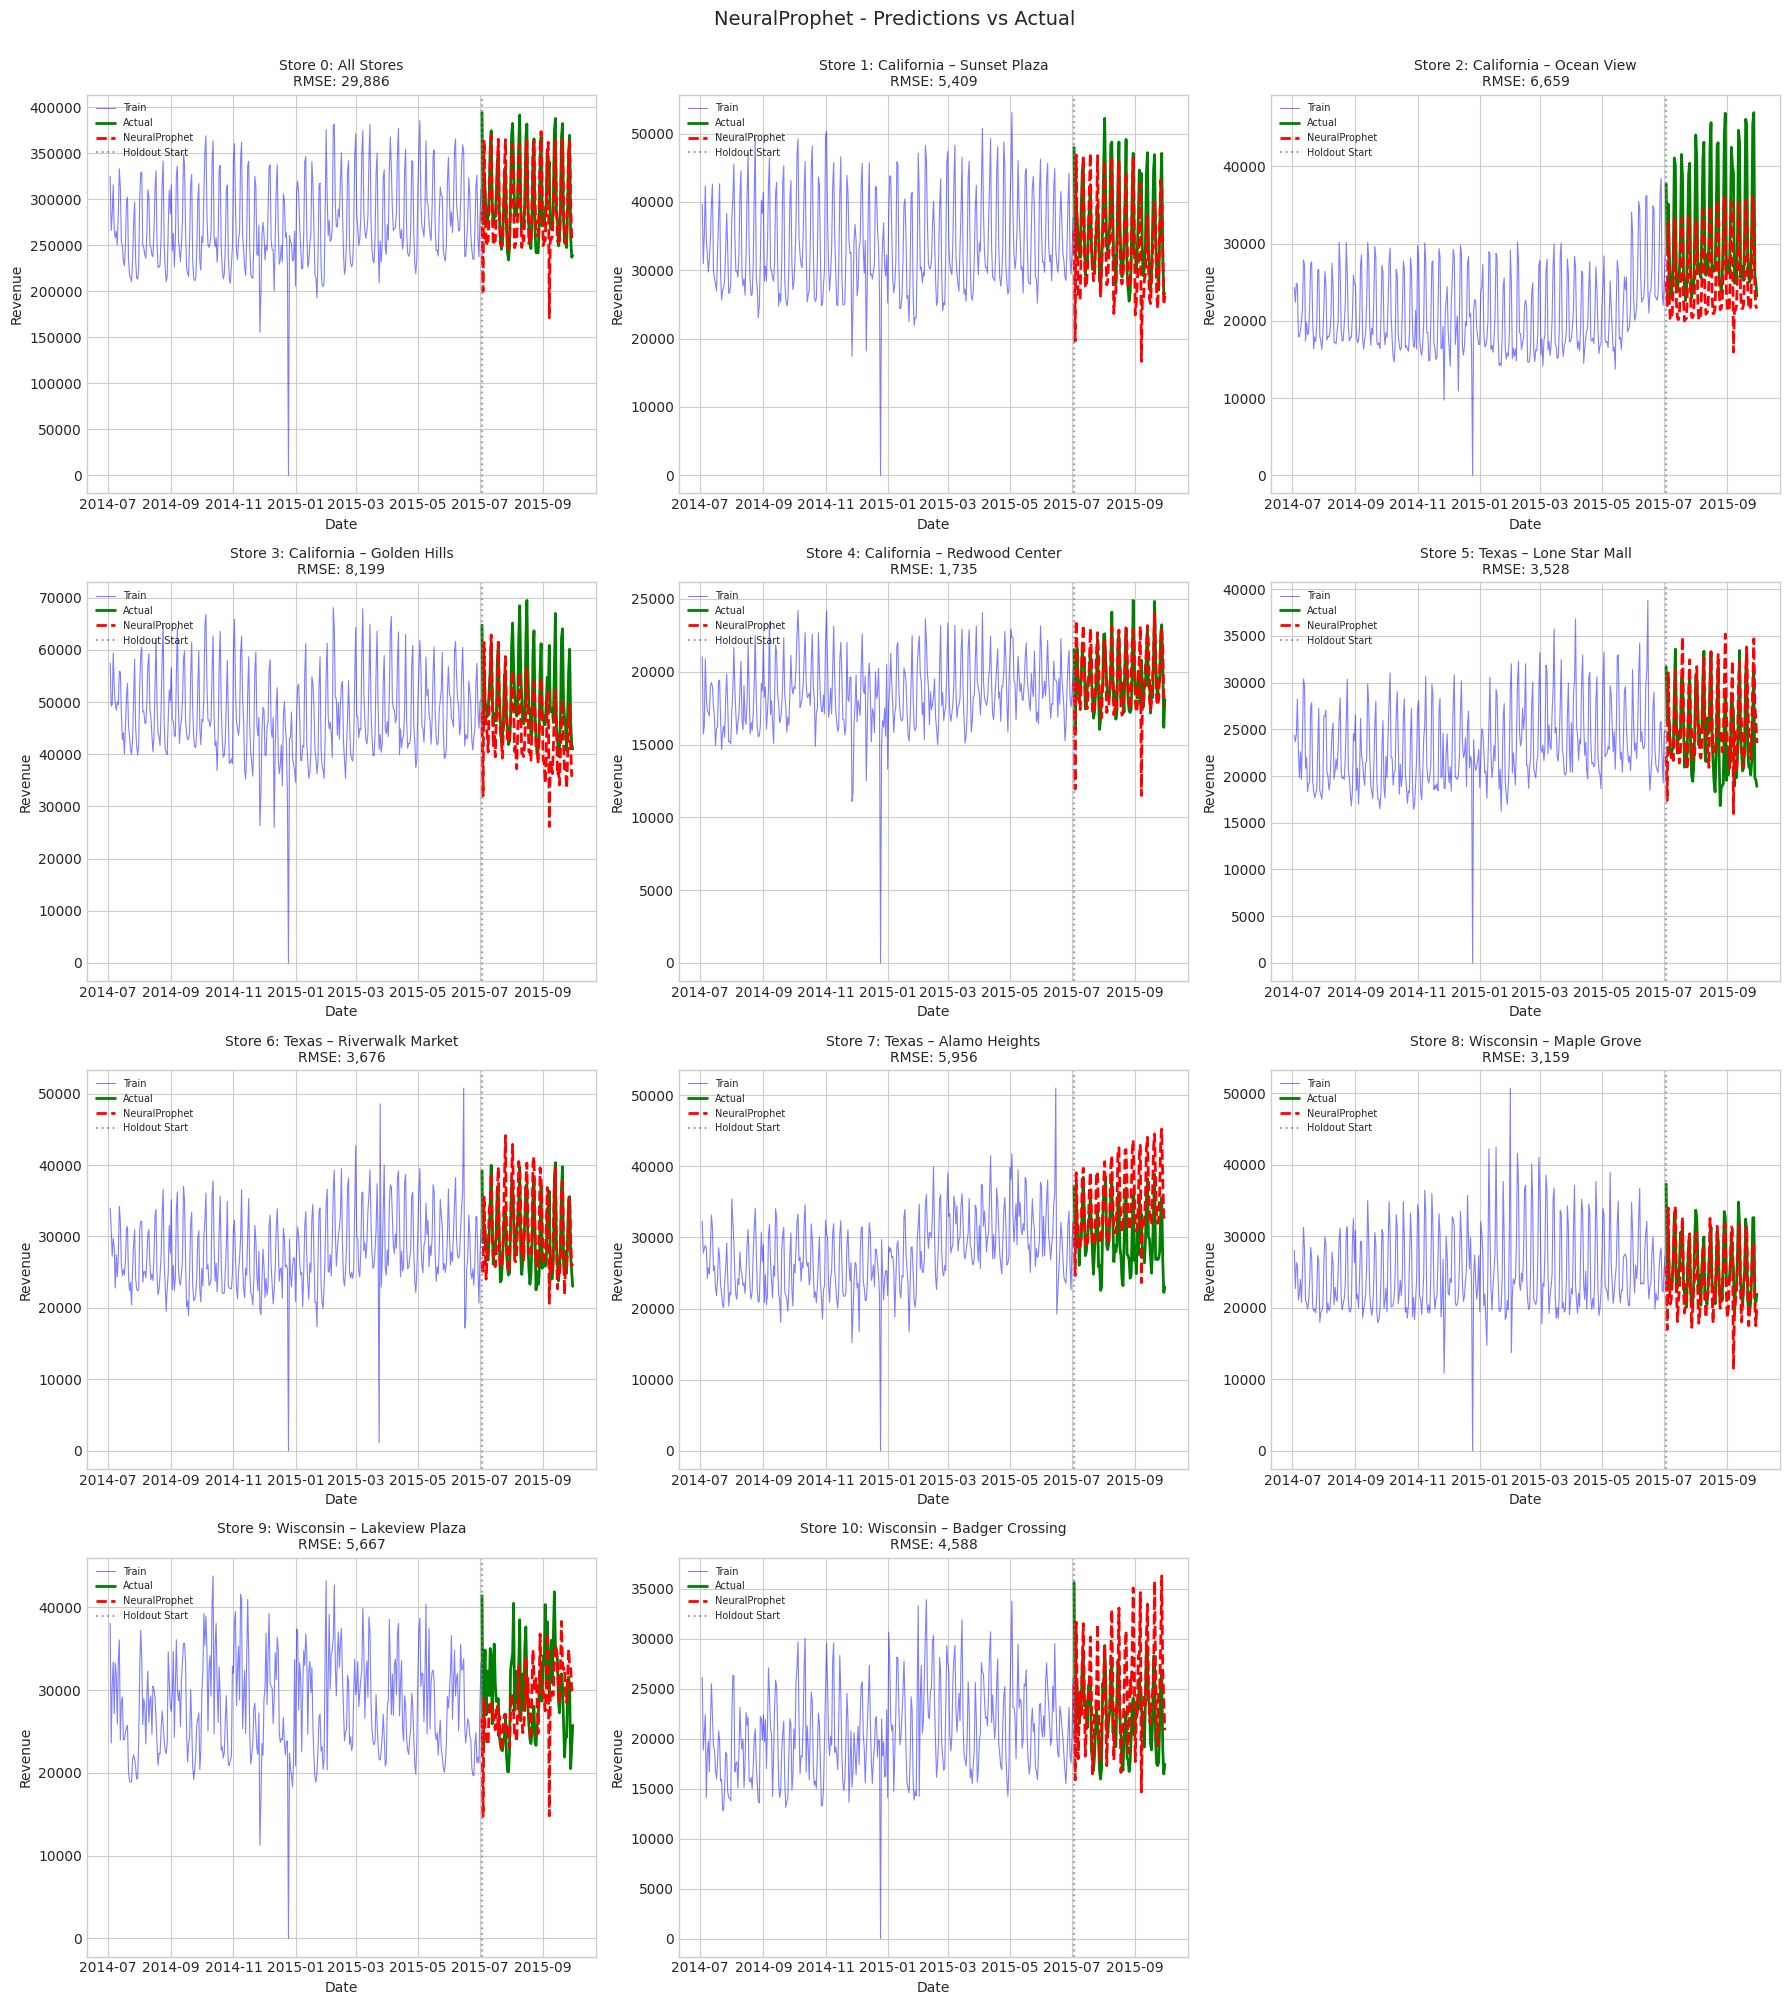

In [15]:
def plot_neuralprophet_predictions(results_df, train_set, n_history_days=365):
    """
    Plot NeuralProphet predictions vs actuals for all stores.
    """
    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.flatten()
    
    store_ids = sorted(results_df['store_id'].unique())
    
    for idx, store_id in enumerate(store_ids):
        ax = axes[idx]
        
        # Get training data
        store_train = train_set[train_set['store_id'] == store_id].copy()
        store_train = store_train.sort_values('date')
        
        # Get holdout data
        store_holdout = results_df[results_df['store_id'] == store_id].sort_values('date')
        
        # Show last n_history_days of training
        holdout_start = store_holdout['date'].min()
        viz_start = holdout_start - pd.Timedelta(days=n_history_days)
        store_train_viz = store_train[store_train['date'] >= viz_start]
        
        # Plot training data
        ax.plot(store_train_viz['date'], store_train_viz['revenue'], 
                color='blue', alpha=0.5, linewidth=0.8, label='Train')
        
        # Plot actual holdout
        ax.plot(store_holdout['date'], store_holdout['revenue'], 
                color='green', linewidth=2, label='Actual')
        
        # Plot predictions
        ax.plot(store_holdout['date'], store_holdout['pred_neuralprophet'], 
                color='red', linestyle='--', linewidth=2, label='NeuralProphet')
        
        # Vertical line at cutoff
        ax.axvline(x=holdout_start, color='gray', linestyle=':', alpha=0.7, label='Holdout Start')
        
        # Store RMSE
        store_rmse = rmse(store_holdout['revenue'].values, 
                         store_holdout['pred_neuralprophet'].values)
        
        store_name = store_holdout['store_name'].iloc[0]
        ax.set_title(f"Store {store_id}: {store_name}\nRMSE: {store_rmse:,.0f}", fontsize=10)
        ax.set_xlabel('Date')
        ax.set_ylabel('Revenue')
        ax.legend(loc='upper left', fontsize=7)
    
    # Hide unused subplot
    axes[-1].axis('off')
    
    plt.suptitle('NeuralProphet - Predictions vs Actual', fontsize=14, y=1.0)
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_neuralprophet_predictions(results_neuralprophet, train_set)

## 10. Generate Final Submission

Train on full dataset and generate predictions for the competition submission period.

In [22]:
# Prepare full training data with events
full_train_with_events = prepare_calendar_features(train_df, calendar_df)

# Parse submission dates
submission_dates = []
for _, row in submission_df.iterrows():
    store_id, date_str = parse_submission_id(row['id'])
    date = pd.to_datetime(date_str, format='%Y%m%d')
    submission_dates.append({
        'id': row['id'],
        'store_id': store_id,
        'date': date
    })

submission_forecast_df = pd.DataFrame(submission_dates)

# Add event features to forecast period
submission_forecast_df = prepare_calendar_features(submission_forecast_df, calendar_df)

print(f"Forecast period: {submission_forecast_df['date'].min()} to {submission_forecast_df['date'].max()}")
print(f"Total predictions needed: {len(submission_forecast_df)}")
SUBMISSION_HORIZON = submission_forecast_df['date'].nunique()

Forecast period: 2015-10-01 00:00:00 to 2015-12-31 00:00:00
Total predictions needed: 1012


In [23]:
full_train_with_events.head()

,store_id,store_name,date,revenue,month,is_weekend,day_of_week,is_major_holiday,is_sports_event,is_religious_event
0,0,All Stores,2011-01-29,204126.52,1,1,5,0,0,0
1,0,All Stores,2011-01-30,197426.42,1,1,6,0,0,0
2,0,All Stores,2011-01-31,144267.27,1,0,0,0,0,0
3,0,All Stores,2011-02-01,151903.00,2,0,1,0,0,0
4,0,All Stores,2011-02-02,117399.88,2,0,2,0,0,0


In [24]:
submission_forecast_df

,id,store_id,date,month,is_weekend,day_of_week,is_major_holiday,is_sports_event,is_religious_event
0,0_20151001,0,2015-10-01,10,0,3,0,0,0
1,0_20151002,0,2015-10-02,10,0,4,0,0,0
2,0_20151003,0,2015-10-03,10,1,5,0,0,0
3,0_20151004,0,2015-10-04,10,1,6,0,0,0
4,0_20151005,0,2015-10-05,10,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1007,10_20151227,10,2015-12-27,12,1,6,0,0,0
1008,10_20151228,10,2015-12-28,12,0,0,0,0,0
1009,10_20151229,10,2015-12-29,12,0,1,0,0,0
1010,10_20151230,10,2015-12-30,12,0,2,0,0,0


In [ ]:
# Train final models on full dataset and generate submission
# Uses the same hyperparameters from the fine-tuning configuration above
print(f"\nTraining final NeuralProphet models on full dataset...")
print(f"Using: epochs={EPOCHS}, n_lags={N_LAGS}, lr={LEARNING_RATE}")
print("="*60)

final_models = {}
final_predictions = []

for store_id in range(1, 11):  # Only stores 1-10
    store_name = train_df[train_df['store_id'] == store_id]['store_name'].iloc[0]
    print(f"\nTraining Store {store_id}: {store_name}...")
    
    # Train on FULL dataset with same hyperparameters
    model, _ = train_neuralprophet_model(
        full_train_with_events, 
        store_id,
        forecast_horizon=SUBMISSION_HORIZON,
        add_regressors=True,
        epochs=EPOCHS,
        n_lags=N_LAGS,
        learning_rate=LEARNING_RATE
    )
    final_models[store_id] = model
    
    # Make predictions for submission period
    preds = predict_neuralprophet(model, full_train_with_events, submission_forecast_df, store_id)
    
    # Store results
    store_submission = submission_forecast_df[submission_forecast_df['store_id'] == store_id].copy()
    store_submission = store_submission.sort_values('date').reset_index(drop=True)
    store_submission['prediction'] = preds
    final_predictions.append(store_submission[['id', 'prediction']])
    
    print(f"  Generated {len(preds)} predictions")
    print(f"  Mean prediction: {preds.mean():,.2f}")
    print(f"  Min: {preds.min():,.2f}, Max: {preds.max():,.2f}")

# Combine predictions for stores 1-10
final_submission = pd.concat(final_predictions, ignore_index=True)



INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.



Training final NeuralProphet models on full dataset...
Using: epochs=100, n_lags=56, lr=0.01

Training Store 1: California – Sunset Plaza...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 31,427.18
  Min: 15,375.54, Max: 44,441.52

Training Store 2: California – Ocean View...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 31,239.86
  Min: 18,857.70, Max: 43,839.80

Training Store 3: California – Golden Hills...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 46,449.99
  Min: 22,034.19, Max: 62,667.92

Training Store 4: California – Redwood Center...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 21,063.89
  Min: 10,016.39, Max: 26,211.86

Training Store 5: Texas – Lone Star Mall...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 22,898.23
  Min: 12,871.11, Max: 30,970.51

Training Store 6: Texas – Riverwalk Market...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 27,785.69
  Min: 15,922.84, Max: 37,204.22

Training Store 7: Texas – Alamo Heights...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 29,802.60
  Min: 17,368.63, Max: 37,953.01

Training Store 8: Wisconsin – Maple Grove...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 23,931.40
  Min: 12,737.02, Max: 36,688.79

Training Store 9: Wisconsin – Lakeview Plaza...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Set

  Generated 92 predictions
  Mean prediction: 28,742.42
  Min: 12,435.52, Max: 38,457.94

Training Store 10: Wisconsin – Badger Crossing...


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 92 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


  Generated 92 predictions
  Mean prediction: 21,006.43
  Min: 10,973.98, Max: 27,295.66

Final submission shape: (1012, 2)

First 10 predictions:
           id    prediction
0  1_20151001  27670.175454
1  1_20151002  33657.591712
2  1_20151003  42256.330759
3  1_20151004  43958.658554
4  1_20151005  33091.582343
5  1_20151006  28663.217481
6  1_20151007  26471.752335
7  1_20151008  27775.165998
8  1_20151009  32240.879744
9  1_20151010  42690.600454

Last 10 predictions:
              id     prediction
1002  0_20151222  222872.117461
1003  0_20151223  218454.477104
1004  0_20151224  216416.183821
1005  0_20151225  148966.314068
1006  0_20151226  297624.585971
1007  0_20151227  296953.133113
1008  0_20151228  239302.429248
1009  0_20151229  212485.813986
1010  0_20151230  204490.725153
1011  0_20151231  205916.231059


In [44]:
final_submission = final_submission[~final_submission['id'].str.startswith('0_')].copy()

In [45]:
# Create Store 0 by summing stores 1-10 predictions
# First, we need to get the predictions with dates (not just id)
store_1_10_preds = submission_forecast_df[submission_forecast_df['store_id'] != 0].copy()
store_1_10_preds = store_1_10_preds.merge(
    final_submission[['id', 'prediction']],
    on='id',
    how='left'
)

# Sum by date to get Store 0
store_0_preds = store_1_10_preds.groupby('date')['prediction'].sum().reset_index()
store_0_preds['store_id'] = 0

# Create submission IDs for Store 0
store_0_preds['id'] = store_0_preds['date'].apply(
    lambda d: f"0_{d.strftime('%Y%m%d')}"
)

# Add Store 0 to final submission
final_submission = pd.concat([
    store_0_preds[['id', 'prediction']],
    final_submission,
], ignore_index=True)

# Ensure predictions are non-negative
final_submission['prediction'] = final_submission['prediction'].clip(lower=0)

print("\n" + "="*60)
print(f"Final submission shape: {final_submission.shape}")
print("\nFirst 10 predictions:")
print(final_submission.head(10))
print("\nLast 10 predictions:")
print(final_submission.tail(10))


Final submission shape: (1012, 2)

First 10 predictions:
           id     prediction
0  0_20151001  260692.786002
1  0_20151002  289388.117437
2  0_20151003  359825.125561
3  0_20151004  360359.537437
4  0_20151005  296541.667494
5  0_20151006  268266.495858
6  0_20151007  259377.973987
7  0_20151008  259785.239609
8  0_20151009  296044.196224
9  0_20151010  360303.489393

Last 10 predictions:
               id    prediction
1002  10_20151222  18665.380153
1003  10_20151223  17599.128260
1004  10_20151224  15605.566064
1005  10_20151225  11347.378385
1006  10_20151226  20569.552247
1007  10_20151227  21762.518406
1008  10_20151228  19043.419172
1009  10_20151229  16804.647221
1010  10_20151230  15953.556974
1011  10_20151231  15300.438662


In [46]:
# Save submission file
submissions_dir = Path('../submissions/neuralprophet')
submissions_dir.mkdir(parents=True, exist_ok=True)

output_path = submissions_dir / 'neuralprophet_submission_nl_1.csv'
final_submission.to_csv(output_path, index=False)

print(f"\n✅ Submission saved to: {output_path}")
print(f"\nSubmission summary:")
print(f"  Total predictions: {len(final_submission)}")
print(f"  Mean prediction: {final_submission['prediction'].mean():,.2f}")
print(f"  Min prediction: {final_submission['prediction'].min():,.2f}")
print(f"  Max prediction: {final_submission['prediction'].max():,.2f}")


✅ Submission saved to: ../submissions/neuralprophet/neuralprophet_submission_nl_1.csv

Submission summary:
  Total predictions: 1012
  Mean prediction: 51,699.58
  Min prediction: 10,016.39
  Max prediction: 360,747.44


## 11. Summary and Next Steps

### Results Summary
- **Holdout RMSE**: (See evaluation above)
- **Competition Baseline**: 11,761
- **Status**: (Check if baseline beaten)

### What NeuralProphet Does Better:
1. **Neural network-based trend modeling** - More flexible than linear trends
2. **Automatic AR-Net** - Uses 28-day lagged values to capture autocorrelation
3. **Multiple seasonalities** - Weekly + yearly patterns learned simultaneously
4. **Calendar event regressors** - Holidays and events directly influence predictions
5. **Changepoint detection** - Automatically detects 10 trend changes

### If Results Are Still Not Good Enough:
1. **Increase training epochs** - Try 200-500 epochs (currently 100)
2. **Tune hyperparameters**:
   - Increase `n_lags` to 56 (8 weeks)
   - Try `d_hidden=64` for larger network
   - Experiment with `loss_func='MSE'` instead of Huber
3. **Add more regressors**:
   - Day of week, month, quarter features
   - Rolling averages as external regressors
4. **Ensemble approach**:
   - Combine NeuralProphet with best baseline model
   - Average predictions for stability
5. **Try other deep learning models**:
   - LSTM, Transformer-based (TimeGPT, Chronos)
   - LightGBM with extensive feature engineering